In [1]:
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, fisher_exact
from scipy.special import softmax
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

from gpn.define_intervals import intersect_intervals
from gpn.utils import Genome, load_table

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading GPN probabilities

In [2]:
MODEL = "gonzalobenegas/gpn-brassicales"

nucleotides = list("ACGT")

d = Path(f"output/whole_genome")
pred = pd.read_parquet(d / "positions.parquet")
computed_intervals = pred.copy().query('chrom=="5"')
computed_intervals["start"] = computed_intervals.pos-1
computed_intervals["end"] = computed_intervals.pos
computed_intervals = bf.merge(computed_intervals)
# perplexity of seeing that particular nucleotide
pred.loc[:, nucleotides] = 1 / softmax(pd.read_parquet(d / "logits" / f"{MODEL}.parquet")[nucleotides].values, axis=1)
pred = pred[pred.chrom=="5"]
pred = pred.melt(id_vars=["chrom", "pos"], var_name="nucleotide", value_name="value").set_index(["chrom", "pos", "nucleotide"]).value
pred

chrom  pos       nucleotide
5      257       A               3.672214
       258       A               3.150046
       259       A               1.538006
       260       A               2.029547
       261       A               2.975541
                                  ...    
       26975242  T               1.578767
       26975243  T               9.383389
       26975244  T               1.715837
       26975245  T             127.358849
       26975246  T               8.319965
Name: value, Length: 107818852, dtype: float32

In [3]:
computed_intervals

,chrom,start,end,n_intervals
0,5,256,10130875,10130619
1,5,10131388,11194213,1062825
2,5,11195104,11202617,7513
3,5,11203695,11210445,6750
4,5,11211593,11216787,5194
5,5,11217300,11217835,535
6,5,11218658,11222652,3994
7,5,11223578,11225708,2130
8,5,11226877,11228030,1153
9,5,11229114,11235391,6277


## Loading annotation

In [4]:
genome = Genome("output/genome.fa.gz", subset_chroms=["5"])

In [5]:
annotation = load_table("output/annotation.gtf.gz").query('chrom=="5"')
annotation

,chrom,source,feature,start,end,score,strand,frame,attribute
609890,5,TAIR10,chromosome,0,26975502,.,.,.,"ID=chromosome:5;Alias=Chr5,CP002688.1,NC_003076.8"
609891,5,araport11,ncRNA_gene,1,303,.,+,.,ID=gene:AT5G00730;Name=AT5G00730;biotype=lncRN...
609892,5,araport11,lnc_RNA,1,303,.,+,.,ID=transcript:AT5G00730.1;Parent=gene:AT5G0073...
609893,5,araport11,exon,1,303,.,+,.,Parent=transcript:AT5G00730.1;Name=AT5G00730.1...
609894,5,araport11,gene,994,5156,.,-,.,ID=gene:AT5G01010;Name=AT5G01010;biotype=prote...
...,...,...,...,...,...,...,...,...,...
790416,5,araport11,lnc_RNA,26971388,26971689,.,+,.,ID=transcript:AT5G09955.1;Parent=gene:AT5G0995...
790417,5,araport11,exon,26971388,26971689,.,+,.,Parent=transcript:AT5G09955.1;Name=AT5G09955.1...
790418,5,araport11,ncRNA_gene,26972176,26972644,.,-,.,ID=gene:AT5G09965;Name=AT5G09965;biotype=lncRN...
790419,5,araport11,lnc_RNA,26972176,26972644,.,-,.,ID=transcript:AT5G09965.1;Parent=gene:AT5G0996...


In [6]:
exons = annotation.query('feature=="exon"').copy()
exons["transcript_id"] = exons.attribute.str.split(";").str[0].str.split(":").str[-1]
exons

,chrom,source,feature,start,end,score,strand,frame,attribute,transcript_id
609893,5,araport11,exon,1,303,.,+,.,Parent=transcript:AT5G00730.1;Name=AT5G00730.1...,AT5G00730.1
609896,5,araport11,exon,994,1225,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.2...,AT5G01010.2
609899,5,araport11,exon,1372,1459,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.2...,AT5G01010.2
609901,5,araport11,exon,1571,1646,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.5...,AT5G01010.2
609903,5,araport11,exon,1744,1780,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.5...,AT5G01010.2
...,...,...,...,...,...,...,...,...,...,...
790408,5,araport11,exon,26969914,26970241,.,-,.,Parent=transcript:AT5G67640.1;Name=AT5G67640.1...,AT5G67640.1
790410,5,araport11,exon,26970311,26970360,.,-,.,Parent=transcript:AT5G67640.1;Name=AT5G67640.1...,AT5G67640.1
790413,5,araport11,exon,26970443,26970668,.,-,.,Parent=transcript:AT5G67640.1;Name=AT5G67640.1...,AT5G67640.1
790417,5,araport11,exon,26971388,26971689,.,+,.,Parent=transcript:AT5G09955.1;Name=AT5G09955.1...,AT5G09955.1


In [7]:
CDSs = annotation.query('feature=="CDS"').copy()
CDSs["CDS_id"] = CDSs.attribute.str.split(";").str[0].str.split(":").str[-1]
CDSs

,chrom,source,feature,start,end,score,strand,frame,attribute,CDS_id
609900,5,araport11,CDS,1387,1459,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...,AT5G01010.2
609902,5,araport11,CDS,1571,1646,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...,AT5G01010.2
609904,5,araport11,CDS,1744,1780,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...,AT5G01010.2
609906,5,araport11,CDS,1913,2007,.,-,1,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...,AT5G01010.2
609908,5,araport11,CDS,2104,2181,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...,AT5G01010.2
...,...,...,...,...,...,...,...,...,...,...
790400,5,araport11,CDS,26968557,26969306,.,-,0,ID=CDS:AT5G67630.1;Parent=transcript:AT5G67630...,AT5G67630.1
790407,5,araport11,CDS,26969545,26969670,.,-,2,ID=CDS:AT5G67640.1;Parent=transcript:AT5G67640...,AT5G67640.1
790409,5,araport11,CDS,26969914,26970241,.,-,2,ID=CDS:AT5G67640.1;Parent=transcript:AT5G67640...,AT5G67640.1
790411,5,araport11,CDS,26970311,26970360,.,-,0,ID=CDS:AT5G67640.1;Parent=transcript:AT5G67640...,AT5G67640.1


In [8]:
def find_elements(df, keep):
    return df.sort_values("start", ascending=df.strand.iloc[0]=="+").iloc[keep]


def find_splice_donors(exons):
    # all exons in a transcript except the last
    my_exons = exons.groupby("transcript_id", sort=False).apply(lambda df: find_elements(df, slice(None, -1)))
    return pd.DataFrame(
        my_exons.apply(
            lambda e: (e.chrom, e.end, e.end+2) if e.strand=="+" else (e.chrom, e.start-2, e.start),
            axis=1, result_type="expand"
        ).values,
        columns=["chrom", "start", "end"],
    ).drop_duplicates()


def find_splice_acceptors(exons):
    # all exons in a transcript except the first
    my_exons = exons.groupby("transcript_id", sort=False).apply(lambda df: find_elements(df, slice(1, None)))
    return pd.DataFrame(
        my_exons.apply(
            lambda e: (e.chrom, e.end, e.end+2) if e.strand=="-" else (e.chrom, e.start-2, e.start),
            axis=1, result_type="expand"
        ).values,
        columns=["chrom", "start", "end"],
    ).drop_duplicates()


def find_start_codons(CDSs):
    # first CDS exon of each ORF
    my_CDSs = CDSs.groupby("CDS_id", sort=False).apply(lambda df: find_elements(df, slice(None, 1)))
    # assuming no splicing within the codon
    return pd.DataFrame(
        my_CDSs.apply(
            lambda e: (e.chrom, e.start, e.start+3) if e.strand=="+" else (e.chrom, e.end-3, e.end),
            axis=1, result_type="expand"
        ).values,
        columns=["chrom", "start", "end"],
    ).drop_duplicates()


def find_stop_codons(CDSs):
    # last CDS exon of each ORF
    my_CDSs = CDSs.groupby("CDS_id", sort=False).apply(lambda df: find_elements(df, slice(-1, None)))
    # assuming no splicing within the codon
    return pd.DataFrame(
        my_CDSs.apply(
            lambda e: (e.chrom, e.start, e.start+3) if e.strand=="-" else (e.chrom, e.end-3, e.end),
            axis=1, result_type="expand"
        ).values,
        columns=["chrom", "start", "end"],
    ).drop_duplicates()

In [9]:
splice_donors = find_splice_donors(exons)
splice_donors["Region"] = "Splice donor"
splice_donors

,chrom,start,end,Region
0,5,4762,4764,Splice donor
1,5,4549,4551,Splice donor
2,5,4332,4334,Splice donor
3,5,4099,4101,Splice donor
4,5,3924,3926,Splice donor
...,...,...,...,...
59498,5,26965195,26965197,Splice donor
59499,5,26968555,26968557,Splice donor
59500,5,26970441,26970443,Splice donor
59501,5,26970309,26970311,Splice donor


In [10]:
splice_acceptors = find_splice_acceptors(exons)
splice_acceptors["Region"] = "Splice acceptor"
splice_acceptors

,chrom,start,end,Region
0,5,4679,4681,Splice acceptor
1,5,4467,4469,Splice acceptor
2,5,4258,4260,Splice acceptor
3,5,4005,4007,Splice acceptor
4,5,3802,3804,Splice acceptor
...,...,...,...,...
59498,5,26965004,26965006,Splice acceptor
59499,5,26968195,26968197,Splice acceptor
59500,5,26970360,26970362,Splice acceptor
59501,5,26970241,26970243,Splice acceptor


In [11]:
start_codons = find_start_codons(CDSs)
start_codons["Region"] = "Start codon"
start_codons

,chrom,start,end,Region
0,5,4921,4924,Start codon
5,5,5766,5769,Start codon
7,5,5338,5341,Start codon
8,5,8267,8270,Start codon
9,5,10637,10640,Start codon
...,...,...,...,...
10985,5,26960223,26960226,Start codon
10986,5,26963611,26963614,Start codon
10988,5,26965717,26965720,Start codon
10989,5,26969303,26969306,Start codon


In [12]:
stop_codons = find_stop_codons(CDSs)
stop_codons["Region"] = "Stop codon"
stop_codons

,chrom,start,end,Region
0,5,1387,1390,Stop codon
4,5,1526,1529,Stop codon
5,5,5334,5337,Stop codon
6,5,5515,5518,Stop codon
7,5,5590,5593,Stop codon
...,...,...,...,...
10985,5,26959753,26959756,Stop codon
10986,5,26961223,26961226,Stop codon
10988,5,26964890,26964893,Stop codon
10989,5,26967534,26967537,Stop codon


In [13]:
annot2 = pd.read_parquet("output/annotation.expanded.parquet", columns=["chrom", "start", "end", "feature"]).query('chrom=="5"')
annot2.loc[annot2.feature=="intron", "start"] += 2
annot2.loc[annot2.feature=="intron", "end"] -= 2
annot2 = bf.subtract(annot2[annot2.feature.isin(["intron", "intergenic"])], annot2[annot2.feature.isin(["exon", "Repeat"])])
annot2

,chrom,start,end,feature
0,5,0,1,intergenic
1,5,303,359,intergenic
2,5,396,932,intergenic
3,5,5156,5248,intergenic
4,5,5907,5916,intergenic
...,...,...,...,...
43769,5,26965381,26965465,intron
43770,5,26968197,26968555,intron
43771,5,26969672,26969912,intron
43772,5,26970243,26970309,intron


In [14]:
annot2 = annot2.groupby("feature").sample(n=300, random_state=42)
annot2 = intersect_intervals(annot2, computed_intervals)
annot2["Region"] = "Intergenic + intronic"
annot2

,chrom,start,end,Region
0,5,2007,2104,Intergenic + intronic
1,5,125819,126128,Intergenic + intronic
2,5,180100,180208,Intergenic + intronic
3,5,187659,187772,Intergenic + intronic
4,5,213593,214372,Intergenic + intronic
...,...,...,...,...
593,5,26818218,26818948,Intergenic + intronic
594,5,26825582,26825670,Intergenic + intronic
595,5,26876855,26877271,Intergenic + intronic
596,5,26961949,26962022,Intergenic + intronic


In [15]:
(annot2.end-annot2.start).sum()

216224

In [16]:
windows = pd.concat([splice_donors, splice_acceptors, start_codons, stop_codons, annot2], ignore_index=True)
windows

,chrom,start,end,Region
0,5,4762,4764,Splice donor
1,5,4549,4551,Splice donor
2,5,4332,4334,Splice donor
3,5,4099,4101,Splice donor
4,5,3924,3926,Splice donor
...,...,...,...,...
74875,5,26818218,26818948,Intergenic + intronic
74876,5,26825582,26825670,Intergenic + intronic
74877,5,26876855,26877271,Intergenic + intronic
74878,5,26961949,26962022,Intergenic + intronic


In [17]:
def find_positions(w):
    df = pd.DataFrame(dict(pos=range(w.start, w.end)))
    df["chrom"] = w.chrom
    df.pos += 1  # we'll treat as 1-based
    df["Region"] = w.Region
    return df

positions = pd.concat(
    windows.progress_apply(find_positions, axis=1).values, ignore_index=True
)
positions

100%|██████████| 74880/74880 [00:52<00:00, 1438.55it/s]


,pos,chrom,Region
0,4763,5,Splice donor
1,4764,5,Splice donor
2,4550,5,Splice donor
3,4551,5,Splice donor
4,4333,5,Splice donor
...,...,...,...
379555,26969511,5,Intergenic + intronic
379556,26969512,5,Intergenic + intronic
379557,26969513,5,Intergenic + intronic
379558,26969514,5,Intergenic + intronic


In [18]:
positions.Region.value_counts()

Region
Intergenic + intronic    216224
Splice acceptor           59698
Splice donor              59322
Stop codon                22383
Start codon               21933
Name: count, dtype: int64

In [19]:
positions["nucleotide"] = positions.progress_apply(lambda x: genome.get_nuc(x.chrom, x.pos).upper(), axis=1)
positions

100%|██████████| 379560/379560 [00:04<00:00, 79447.95it/s]


,pos,chrom,Region,nucleotide
0,4763,5,Splice donor,A
1,4764,5,Splice donor,C
2,4550,5,Splice donor,A
3,4551,5,Splice donor,C
4,4333,5,Splice donor,A
...,...,...,...,...
379555,26969511,5,Intergenic + intronic,T
379556,26969512,5,Intergenic + intronic,A
379557,26969513,5,Intergenic + intronic,A
379558,26969514,5,Intergenic + intronic,C


In [20]:
positions["Perplexity"] = pred[pd.MultiIndex.from_frame(positions[["chrom", "pos", "nucleotide"]])].values
positions

,pos,chrom,Region,nucleotide,Perplexity
0,4763,5,Splice donor,A,1.015638
1,4764,5,Splice donor,C,1.013000
2,4550,5,Splice donor,A,1.007265
3,4551,5,Splice donor,C,1.009663
4,4333,5,Splice donor,A,1.084395
...,...,...,...,...,...
379555,26969511,5,Intergenic + intronic,T,2.176358
379556,26969512,5,Intergenic + intronic,A,1.900367
379557,26969513,5,Intergenic + intronic,A,1.827518
379558,26969514,5,Intergenic + intronic,C,3.235990


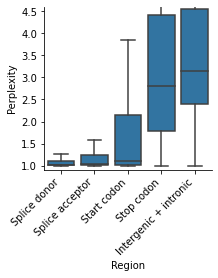

In [49]:
plt.figure(figsize=(3,3))
g = sns.boxplot(data=positions, x="Region", y="Perplexity", color="C0", fliersize=0)
plt.ylim(0.9, 4.6)
#plt.ylim(0.9, 9)
sns.despine()
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right');
#plt.savefig("output/plots/motif_perplexity.pdf", bbox_inches="tight")

Text(0, 0.5, 'Median perplexity')

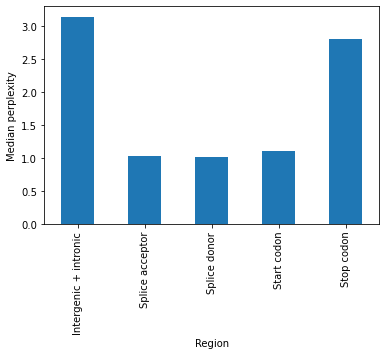

In [23]:
positions.groupby("Region").Perplexity.median().plot(kind="bar")
plt.ylabel("Median perplexity")

In [24]:
positions.groupby("Region").Perplexity.median()

Region
Intergenic + intronic    3.143809
Splice acceptor          1.026111
Splice donor             1.016612
Start codon              1.103932
Stop codon               2.811631
Name: Perplexity, dtype: float32

In [25]:
for Region in positions.Region.unique():
    if Region=="Intergenic + intronic": continue
    print(Region, mannwhitneyu(positions[positions.Region==Region].Perplexity, positions[positions.Region=="Intergenic + intronic"].Perplexity, alternative="less"))

Splice donor MannwhitneyuResult(statistic=1060634299.5, pvalue=0.0)
Splice acceptor MannwhitneyuResult(statistic=1320875832.0, pvalue=0.0)
Start codon MannwhitneyuResult(statistic=795179236.5, pvalue=0.0)
Stop codon MannwhitneyuResult(statistic=2095323030.5, pvalue=2.538610548138552e-240)
